In this notebook we will look into creating multiple models and fine tuning them to get the best possible results.

I will be using the following models:
1. BaggingClassifier
2. RandomForestClassifier
3. ExtraTreesClassifier
4. VotingClassifier (with TBD models)
5. GaussianNB
6. KNeighborsClassifier
7. MLPClassifier
8. LinearTreeClassifier
9. LinearForestClassifier
10. LinearBoostClassifier

The choise of the models are not based on any specific reason, but rather to try out different models and see how they perform. There is although one condition, the model needs to be able to give a probability output, as this will be used in order to give a confidence score.

In [2]:
from sklearn.ensemble import BaggingClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
from sklearn.ensemble import RandomForestClassifier #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier
from sklearn.naive_bayes import GaussianNB #https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
from sklearn.neighbors import KNeighborsClassifier #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
from sklearn.neural_network import MLPClassifier #https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
from lineartree import LinearTreeClassifier, LinearForestClassifier, LinearBoostClassifier #https://github.com/cerlymarco/linear-tree
from sklearn.linear_model import RidgeClassifier, Ridge
from sklearn.multiclass import OneVsRestClassifier

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from joblib import dump, load
import pandas as pd
import os.path
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%run data-cleaning.ipynb
%run model.py

In [5]:
# df = pd.read_csv(r"dataset-prorail-clean-3.csv")
df = pd.read_csv(r"C:\GitHub\jaar 2\groeps project prorail\dataset-prorail-clean-3.csv")
df = clean_data(df)

df['duur_prog_fh_seconds'] = df['duur_prog_fh'].dt.total_seconds()
num_bins = [0.0, 0.15, 0.3, 0.45, 0.55, 0.65, 0.75, 0.85, 0.904, 0.945, 0.97, 0.99, 1.0]
df, bin_edges = create_bins(df, 'duur_prog_fh_seconds', num_bins)
label_encoder = LabelEncoder()
df['duur_prog_fh_seconds_bins_enc'] = label_encoder.fit_transform(df['duur_prog_fh_seconds_bins'])

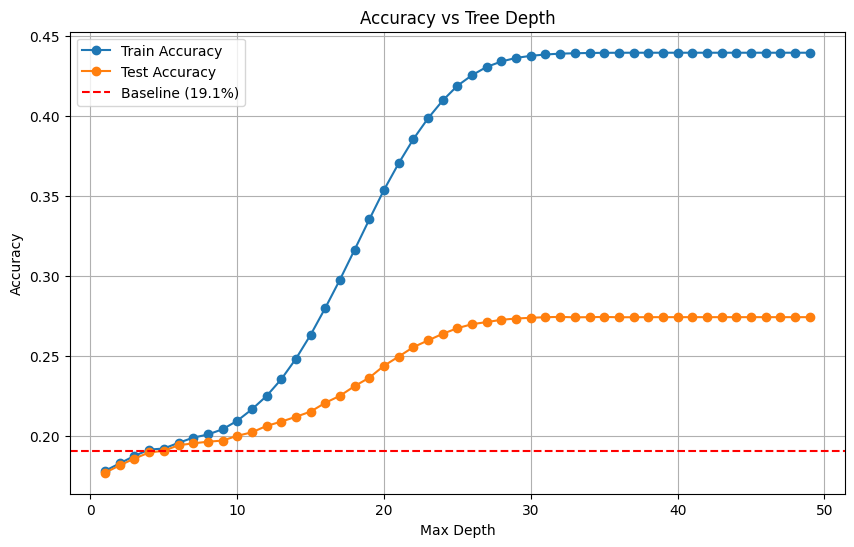

In [10]:
# Definieer de features en target
features = ['stm_geo_mld', 'stm_prioriteit', 'stm_oorz_code', 'stm_contractgeb_gst', 'stm_techn_mld']
target = 'duur_prog_fh_seconds_bins_enc'

# Maak de feature- en target datasets
df_model = df[features]
df_target = df[target]

# Verdeel de DataFrame in features (X) en target (y)
X = df_model
y = df_target

# Initialiseer de LabelEncoder
label_encoder = LabelEncoder()

# Encodeer alle categorische kolommen in X
for col in X.select_dtypes(include=['object']).columns:
    X[col] = label_encoder.fit_transform(X[col])

# Verdeel de data in training- en testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lijsten om de prestaties bij verschillende dieptes op te slaan
train_accuracies = []
test_accuracies = []
depth_range = range(1, 50)  # Verander deze waarde voor meer of minder diepte

# Baseline waarde van 19.1%
baseline = 0.191  # 19.1% als decimale waarde

# Loop door verschillende max_depth waarden en train het model
for depth in depth_range:
    clf = DecisionTreeClassifier(random_state=42, max_depth=depth)
    clf.fit(X_train, y_train)
    
    # Maak voorspellingen voor training en test
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    
    # Bereken de nauwkeurigheid voor beide sets
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    
    # Sla de nauwkeurigheden op
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Maak de grafiek
plt.figure(figsize=(10, 6))
plt.plot(depth_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(depth_range, test_accuracies, label='Test Accuracy', marker='o')
plt.axhline(y=baseline, color='r', linestyle='--', label='Baseline (19.1%)')  # Voeg de baseline toe
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
import itertools

# Label encode categorical features
label_encoder = LabelEncoder()
for col in df[features]:
    if df[col].dtype == 'object':  # Check if the column is categorical
        df[col] = label_encoder.fit_transform(df[col])

# Definieer de hyperparameter zoekruimte
hyperparameter_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [15],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Zet de DataFrame voor features en target
features = ['stm_geo_mld', 'stm_prioriteit', 'stm_oorz_code', 'stm_contractgeb_gst', 'stm_techn_mld']
target = 'duur_prog_fh_seconds_bins_enc'
df_model = df[features]
df_target = df[target]

# Split de data
X_train, X_test, y_train, y_test = train_test_split(df_model, df_target, test_size=0.2, random_state=42)

# Genereer alle mogelijke combinaties van hyperparameters
keys = hyperparameter_grid.keys()
values = (hyperparameter_grid[key] for key in keys)
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Variabelen voor de beste score en parameters
best_score = 0
best_params = {}

# Loop door alle hyperparameter combinaties
for params in combinations:
    model = DecisionTreeClassifier(**params)
    model.fit(X_train, y_train)

    # Maak voorspellingen
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    # Bereken log loss indien mogelijk
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
        log_loss_proba = log_loss(y_test, proba)
    else:
        log_loss_proba = None

    # Print de resultaten als de nauwkeurigheid boven de drempel is
    print(f"Parameters: {params} - Accuracy: {score:.4f} - Log Loss: {log_loss_proba}")

    # Update de beste score en parameters
    if score > best_score:
        best_score = score
        best_params = params

# Print de beste parameters en score
print("\nBeste parameters:", best_params)
print("Beste score:", best_score)
print("Log Loss: ", log_loss_proba)

# Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None}
# Accuracy: 0.21595279300067302
# Log Loss: 2.9997619494671772

Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': None} - Accuracy: 0.2127 - Log Loss: 3.349363474819965
Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': 'balanced'} - Accuracy: 0.1503 - Log Loss: 3.3609500490216866
Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': None} - Accuracy: 0.2145 - Log Loss: 3.32982116084611
Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'class_weight': 'balanced'} - Accuracy: 0.1546 - Log Loss: 3.5183183493196717
Parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': '

In [5]:
features = ['stm_geo_mld', 'stm_prioriteit', 'stm_oorz_code', 'stm_contractgeb_gst', 'stm_techn_mld']
target = 'duur_prog_fh_seconds_bins_enc'
df_model = df[features]
df_target = df[target]

x_train, x_test, y_train, y_test = train_test_split(df_model, df_target, test_size=0.2, random_state=42)
print(os.path.isfile('pipe.joblib'))
if not os.path.isfile('pipe.joblib'):
    pipe = Pipeline([('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform="pandas")), ('bc', BaggingClassifier())])
    pipe.fit(x_train, y_train)
    dump(pipe, 'pipe.joblib')
else:
    pipe = load('pipe.joblib')


print(df_model.iloc[0])

pipe.score(x_test, y_test)
print(pipe.predict_proba([[1, 2, 215, 5, 13]]))

train_models(models, x_train, x_test, y_train, y_test)

True
stm_geo_mld             63.0
stm_prioriteit           4.0
stm_oorz_code          215.0
stm_contractgeb_gst     26.0
stm_techn_mld              S
Name: 129628, dtype: object
[[0.05904762 0.03357143 0.1210989  0.00571429 0.05357143 0.36153846
  0.28212454 0.         0.05       0.         0.03333333 0.        ]]
Training models...
BaggingClassifier - 0.2727261801749832 - 6.902838001491143
RandomForestClassifier - 0.27500961446014804 - 5.058873432769105
ExtraTreesClassifier - 0.27589895202384385 - 7.095764210620535
GaussianNB - 0.01770262474762042 - 35.301451668487765
NearestNeighborsClassifier - 0.2240169214498606 - 15.542592400182311
MLPClassifier - 0.21966637823286222 - 2.1922241176376365
LinearTreeClassifier - 0.21094125564849533 - 28.44055988505763
LinearForestClassifier - 0.27462503605422556 - 2.6752959082498577
LinearBoostClassifier - 0.20216806076338814 - 28.756777880611608
VotingClassifier - 0.2746490722045957 - 2.421253213789961
DecisionTreeClassifier - 0.2751297952119989 - 

In [10]:
# RFC = RandomForestClassifier()
# RFC.fit(x_train, y_train)
print(x_test.shape)

(98905, 504)


So just looking at the base models without hyper tuning we can see some models definatlly are performing better than others. Because of this we have decided to continue with the following few to see if we can improve the performance:
1. RandomForestClassifier
2. LinearForestClassifier
3. ExtraTreesClassifier
4. BaggingClassifier
5. DesicionTreeClassifier

In [17]:
import warnings
warnings.simplefilter('ignore')
BC = BaggingClassifier()
BC_Parameters = {'estimator': [LinearTreeClassifier(base_estimator=RidgeClassifier()), OneVsRestClassifier(LinearForestClassifier(Ridge(), max_features="sqrt")), RandomForestClassifier(), ExtraTreesClassifier(), MLPClassifier(), KNeighborsClassifier(), GaussianNB()], 'n_estimators': [10, 50, 100], 'max_samples': [0.5, 1.0], 'max_features': [0.5, 1.0], 'bootstrap': [True, False], 'bootstrap_features': [True, False], 'random_state': [42]}
RFC_Parameters = {'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [None, 10, 50, 100], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2'], 'random_state': [42]}
ETC_Parameters = {'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth': [None, 10, 50, 100], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2'], 'random_state': [42]}
LFC_Parameters = {'n_estimators': [10, 50, 100], 'base_estimator': [Ridge()],'max_depth': [None, 10, 50, 100], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2'], 'random_state': [42]}
DTC_Parameters = {'criterion': ['gini', 'entropy', 'log_loss'], 'splitter': ['best', 'random'], 'max_depth': [None, 10, 50, 100], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['sqrt', 'log2'], 'random_state': [42]}
GSCV = GridSearchCV(BC, BC_Parameters, n_jobs=-1)
GSCV.fit(x_train, y_train)
print(GSCV.cv_results_)
print(GSCV.best_params_)

KeyboardInterrupt: 